# 6.5~6.7 자전거 대여 수요 예측 경진대회 모델 성능 개선

- 베이스라인 모델과 성능 개선 프로세스 비교
 - 피처 엔지니어링을 본격적으로 수행
 - 모델 훈련 단계에서 하이퍼파라미터 최적화 수행
 - 성능이 만족스럽지 못하면 피처 엔지니어링이나 하이퍼파라미터 최적화를 더 고민해봄

      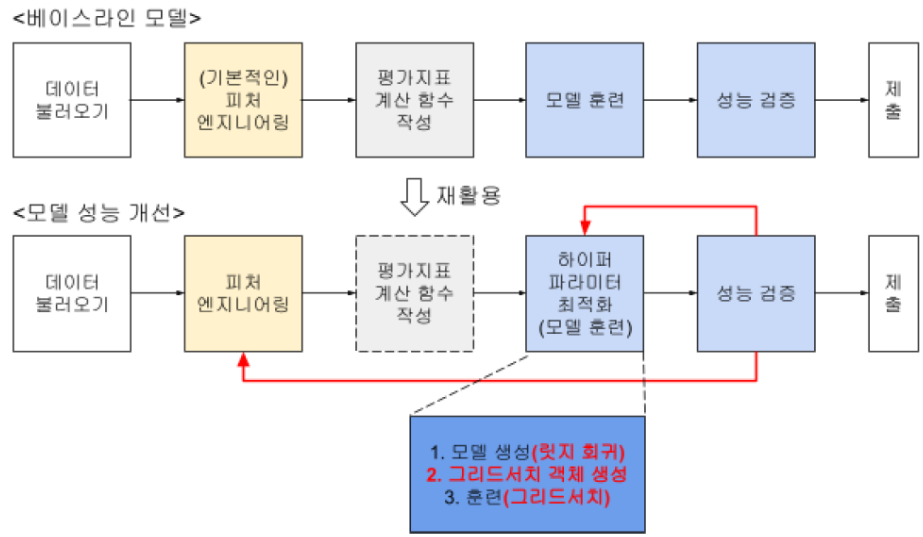
      
 - 이번 장은 튜토리얼이므로 피처 엔지니어링을 추가로 진행하지 않음
 - 그러니 베이스라인용 노트북을 복사한 뒤, ‘데이터 불러오기’ → ‘피처 엔지니어링’ → ‘평가지표 계산 함수 작성’까지 실행해주세요!

In [2]:
import pandas as pd
# 데이터 경로
data_path = 'C:\\vscode\\kaggle\\dataset\\bike-sharing-demand_dat\\'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 피처 엔지니어링

### 이상치 제거

In [3]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

In [4]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생 변수(피처) 추가

In [5]:
all_data['datetime'] = pd.to_datetime(all_data['datetime']) # datetime 타입으로 바꾸기

all_data['year'] = all_data['datetime'].dt.year         # 연도
all_data['month'] = all_data['datetime'].dt.month       # 월
all_data['hour'] = all_data['datetime'].dt.hour         # 시간
all_data['weekday'] = all_data['datetime'].dt.weekday # 요일 (day_name 요일은 문자열로, weekday는 숫자로 반환)

### 필요 없는 피처 제거

In [6]:
drop_features = ['casual', 'registered', 'datetime', 'month', 'windspeed']

all_data = all_data.drop(drop_features, axis=1)

### 데이터 나누기

In [7]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

## 평가지표 계산 함수 작성

In [8]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

<피쳐선택시>

-> 상관계수, 피쳐 중요도 등 여러 참고자료 기반으로 공통적으로 주는 정보를 반영 
특정 수치값 기반해서 일괄적용하는 것은 성능 썩 높아지지 않음

-> 피쳐 개별적으로 그래프 그려보고
여러개 피쳐들로도 그려보면서 
직접 피쳐 중요도를 파악하는 것이 더 중요함 


-> 그럼에도 불구하고 피쳐 제거했는데 
train/ test 분포 다를 때 
여러 참고자료만으로 특정 피쳐에 있는 패턴을 찾지 못했을 수도 있음 


# 6.5 성능 개선 I : 릿지 회귀 모델
- L2 규제를 적용한 선형 회귀 모델
 - 규제(regularization)란 모델이 훈련 데이터에 과대적합(overfitting)되지 않도록 해주는 방법
 - 훈련 데이터에 과대적합되면 모델이 훈련 데이터에만 너무 잘 들어맞고, 테스트 데이터로는 제대로 예측하지 못함

## 6.5.1 하이퍼 파라미터 최적화(모델 훈련)
#### 그리드서치
- 그리드서치(grid search)는 하이퍼파라미터 최적화 기법 중 하나로, 격자(grid)처럼 촘촘하게 순회하며 최적 하이퍼파라미터 값을 찾는 기법
- 각 하이퍼파라미터를 적용한 모델마다 교차 검증(cross-validation)하며 성능을 측정해 최종적으로 성능이 가장 좋았을 때의 하이퍼파라미터 값을 찾음
- 그리드서치를 이용하지 않으면 수작업으로 하이퍼파라미터 값을 전달해서 성능을 측정 해야 함

    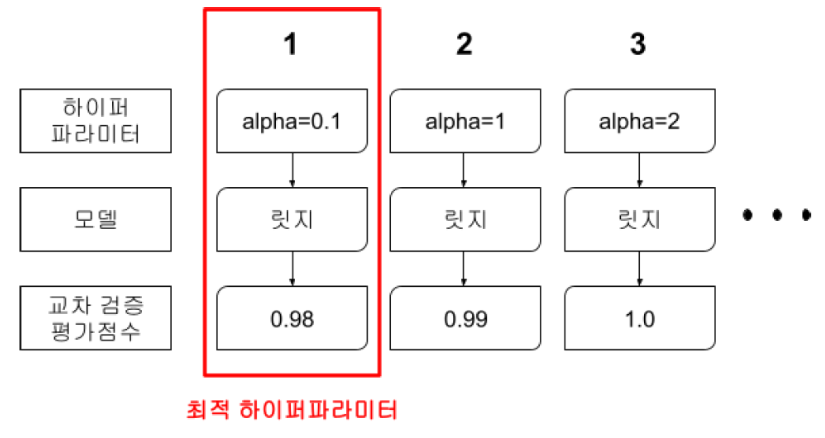

- 그리드서치가 추가되면서 하이퍼파라미터 최적화 절차는 다음과 같이 세분화됨

  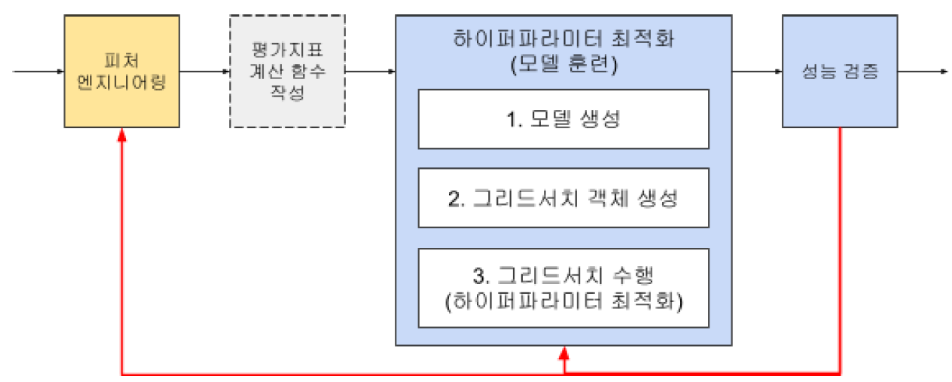


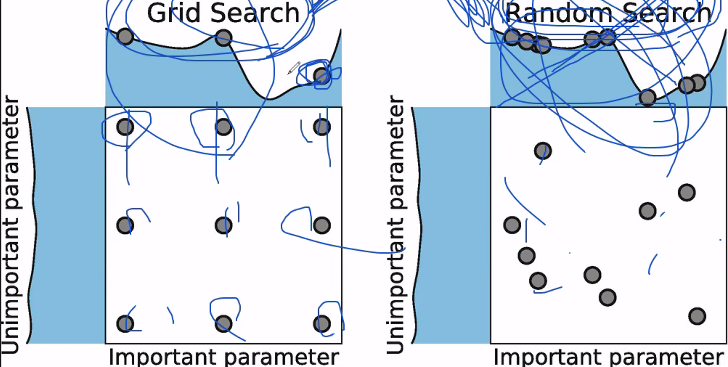

랜덤서치보다 그리디 서치가 성능이 좋긴함
랜덤서치 -> andom하게 일부의 parameter 들만 관측한 후, 그 중에서 가장 좋은 parameter를 선택 

베이지안 최적화도 있음 -> 매번 탐색시 사전지식 반영 / 체계적 탐색 수행 

하이퍼파라미터 최적화 정리 블로그 -> https://wooono.tistory.com/102

### 모델 생성

- 릿지 모델 생성

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

### 그리드서치 객체 생성
- 그리드서치의 원리
 - ‘하이퍼파라미터의 값’을 바꿔가며 ‘모델’의 성능을 교차 검증으로 ‘평가’해 최적 하이퍼파라미터를 찾음
- 그리드서치 객체는 다음 세 가지를 알고 있어야 함
 - 1) 비교 검증해볼 하이퍼파라미터 값 목록
 - 2) 대상 모델
 - 3) 교차 검증용 평가 수단(평가 함수)

In [14]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
# max_iter x alpha = 총 순회수 (현재는 1x10 = 10번 계산후 결과도출) / max_iter':[3000,1000,2000] 이면 3x10 =30번 순회함 
# 교차 검증용 평가 함수(RMSLE 점수 계산) # 오차이므로 값 작을수록 좋음 
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# R^2일경우 클수록 좋으니 greater_is_better=TRUE로 설정함
# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수
# 웬만하면 5 데이터 크면 7 / 크게해줘도 딱히 차이 없음 

분할개수 cv = 5
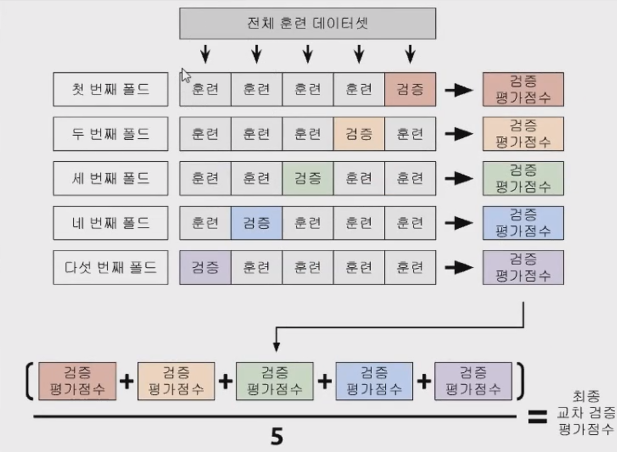

### 그리드서치 수행
- 방금 만든 그리드서치 객체를 이용해 그리드서치 수행
 - fit( ) 메서드를 실행하면 객체 생성 시 param_grid에 전달한 값을 순회하면서, 교차 검증으로 평가지표 점수를 계산함
 - 이때 가장 좋은 성능을 보인 값을 best_params_ 속성에 저장하며, 최적 값으로 훈련한 모델(최적 예측기)을 best_estimator_ 속성에 저장함

In [15]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

# 파이퍼 파라미터 많으면 여러번 순회한다면 시간 매우 많이 걸림
# 큼직하게 범위 짜고 알파, 베타에 
# 이후 찾은 범위 기준 근방으로 잘라서 찾음 - 좁혀가며 찾기 
# 최적 파라미터를 못찾을 수도 있음 
# 처음에는 다른사람들거 참고하고 
# 나중에 대충 어느정도 값 가질때 성능좋구나를 경험적으로 깨닫게도됨

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

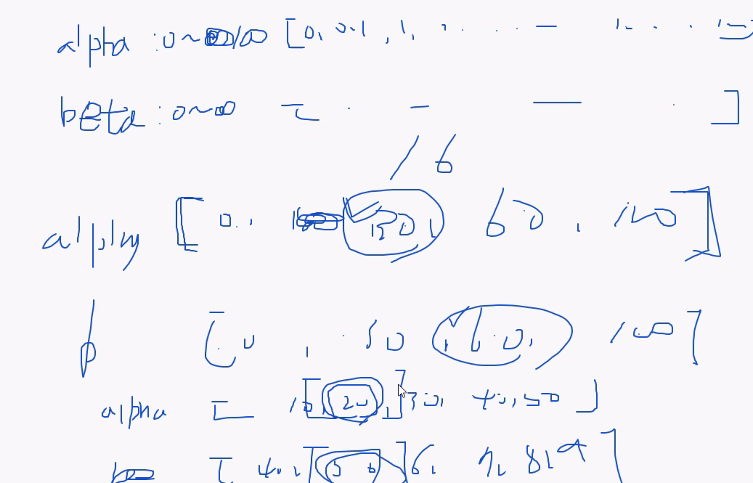

- 최적 하이퍼파라미터 값 확인

In [16]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


In [17]:
gridsearch_ridge_model.best_estimator_ 
# best_estimator_최적 파라미터로 훈련된 모델을 이미 가지고 있음 또 훈련할 필요 없음 

Ridge(alpha=0.1, max_iter=3000)

## 6.5.2 성능 검증
- 최적 예측기를 활용해 성능 검증

In [18]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

릿지 회귀 RMSLE 값 : 1.0205


- 선형 회귀 모델 결과와 다르지 않아서 결과는 굳이 제출하지 않음

# 6.6 성능 개선 II : 라쏘 회귀 모델

## 6.6.1 하이퍼 파라미터 최적화(모델 훈련)
- 전체 흐름은 릿지 회귀 때와 똑같음

In [20]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}



최적 하이퍼파라미터 찾기
하이퍼 파라미터 많으면 여러번 일일히 순회시 시간 매우 많이 걸림 

하이퍼파라미터 알파, 베타, 감마 ... 등등 값을 초기에 큰범위로 자르고
점점 작은 범위로 촘촘하게 자르며 그리드 서치 수행 

물론 최적값을  못찾을 수도 있지만 
제한된 시간속에서 가장 합리적인 방법으로 찾기를 시도하는것임 

처음에는 다른사람들 최적값 코드 참고하고 
나중에 대충 어느정도 값 가질때 성능좋구나를 경험적으로 깨닫게됨 


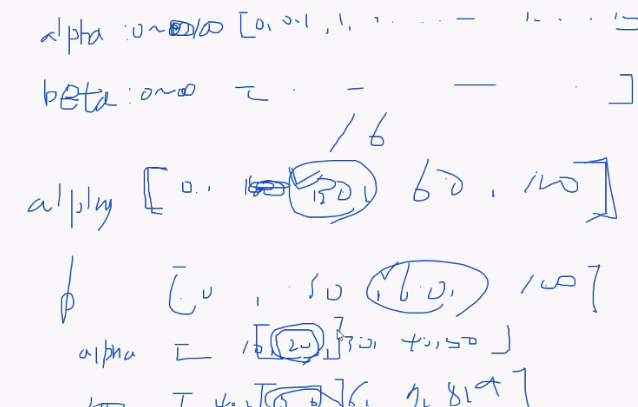


## 6.6.2 성능 검증
- 최적 예측기를 활용해 성능 검증

## 6.6.2 성능 검증
- 최적 예측기를 활용해 성능 검증

In [21]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


- 여전히 성능이 개선되지 않아 이번에도 결과를 제출하지 않음

# 6.7 성능 개선 III : 랜덤 포레스트 회귀 모델

## 6.7.1 하이퍼 파라미터 최적화(모델 훈련)
- 랜덤 포레스트 회귀 모델로 최적 하이퍼파라미터 값 구하기
데이터 사이즈크고 좋은 모델 사용시 그리드 서치 시간 오래걸림 aka)lightXGboost  
-> 대안 : 베이지안 최적화 - 좀더 빠르고 효율적으로 찾음 

베이지안 최적화 예시코드 - 신백균님 코드 참고 https://www.kaggle.com/code/werooring/ch8-lgb-modeling


In [23]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


## 6.7.2 모델 성능 검증
- 최적 예측기로 성능 확인

In [24]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


- RMSLE가 1.02이었던 선형 회귀, 릿지, 라쏘에 비해 큰 폭으로 개선됨(0.1127)
- 네 모델 가운데 가장 우수한 모델은 랜덤 포레스트 회귀

## 6.7.3 예측 및 결과 제출

In [25]:
# 예측
randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False) # 예측 결과를 csv 파일로 저장

- 193등 (상위 6.0%)  ( 2015년 대회이기때문 등수 매우 높음 lightgbm같은 모델 없었음 )